In [1]:
# df["Memory"].value_counts()

In [2]:
# def convert_memory(memory):
#     try:
#         if 'GB' in memory:
#             return int(float(memory.replace('GB', '').strip()))
#         elif 'TB' in memory:
#             return int(float(memory.replace('TB', '').strip()) * 1024)
#     except ValueError:
#         return 0

# df["Memory"] = df["Memory"].apply(lambda x: convert_memory(x.split()[0]))

In [3]:
# df["Memory"].value_counts()

In [4]:
# df["Ips"] = [1 if 'IPS' in i else 0 for i in df["ScreenResolution"]]

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits


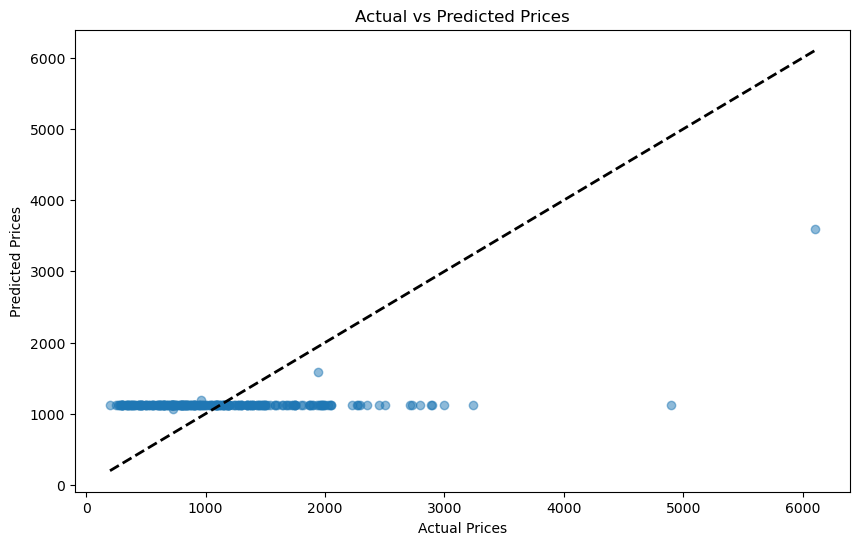

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("laptop_price.csv", encoding='latin1')

# Drop unnecessary columns
df.drop("laptop_ID", inplace=True, axis=1)

# Feature engineering
df["Touchscreen"] = df["ScreenResolution"].apply(lambda x: 1 if 'Touchscreen' in x else 0)
df["Ips"] = df["ScreenResolution"].apply(lambda x: 1 if 'IPS' in x else 0)

# Handle different memory types
def convert_memory(memory):
    try:
        if 'GB' in memory:
            return int(float(memory.replace('GB', '').strip()))
        elif 'TB' in memory:
            return int(float(memory.replace('TB', '').strip()) * 1024)
    except ValueError:
        return 0

df["Memory"] = df["Memory"].apply(lambda x: convert_memory(x.split()[0]))

# One-hot encoding for categorical features
df = pd.get_dummies(df, drop_first=True)

# Split data
x = df.drop("Price_euros", axis=1)
y = df["Price_euros"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Standard scaling
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Feature selection using RFE
model = LinearRegression()
selector = RFE(model, n_features_to_select=10, step=1)
selector = selector.fit(x_train, y_train)
selected_features = x.columns[selector.support_]
x_train_selected = selector.transform(x_train)
x_test_selected = selector.transform(x_test)

# Model training and evaluation
def evaluate_model(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2, y_pred

# Linear Regression
model_lr = LinearRegression()
mse_lr, r2_lr, y_pred_lr = evaluate_model(model_lr, x_train_selected, x_test_selected, y_train, y_test)

# Decision Tree Regressor
model_dt = DecisionTreeRegressor(random_state=42)
mse_dt, r2_dt, y_pred_dt = evaluate_model(model_dt, x_train_selected, x_test_selected, y_train, y_test)

# Random Forest Regressor with GridSearchCV
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=5, n_jobs=-1, verbose=1)
grid_search_rf.fit(x_train_selected, y_train)
best_rf = grid_search_rf.best_estimator_
mse_rf, r2_rf, y_pred_rf = evaluate_model(best_rf, x_train_selected, x_test_selected, y_train, y_test)

# Gradient Boosting Regressor with GridSearchCV
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
grid_search_gb = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_gb, cv=5, n_jobs=-1, verbose=1)
grid_search_gb.fit(x_train_selected, y_train)
best_gb = grid_search_gb.best_estimator_
mse_gb, r2_gb, y_pred_gb = evaluate_model(best_gb, x_train_selected, x_test_selected, y_train, y_test)

# XGBoost Regressor with RandomizedSearchCV
param_dist_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.3, 0.7, 1.0],
    'subsample': [0.3, 0.7, 1.0]
}
random_search_xgb = RandomizedSearchCV(XGBRegressor(random_state=42), param_distributions=param_dist_xgb, n_iter=50, cv=5, n_jobs=-1, verbose=1, random_state=42)
random_search_xgb.fit(x_train_selected, y_train)
best_xgb = random_search_xgb.best_estimator_
mse_xgb, r2_xgb, y_pred_xgb = evaluate_model(best_xgb, x_train_selected, x_test_selected, y_train, y_test)

# Cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_results = cross_val_score(best_rf, x, y, cv=cv, scoring='r2')

# Scatter plot of actual vs predicted prices for the best model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()

# Results
results = {
    'Linear Regression': (mse_lr, r2_lr),
    'Decision Tree': (mse_dt, r2_dt),
    'Random Forest': (mse_rf, r2_rf),
    'Gradient Boosting': (mse_gb, r2_gb),
    'XGBoost': (mse_xgb, r2_xgb),
    'Cross-validated R2': (cv_results.mean(), cv_results.std())
}
